In [1]:
import multiprocessing
import os
from re import A
from typing import ItemsView

from py import log
os.environ['PYTHONDONTWRITEBYTECODE'] = '1'
from xtquant import xttrader
from xtquant.xttrader import XtQuantTrader, XtQuantTraderCallback
from xtquant.xttype import StockAccount
from xtquant import xtconstant
import pandas_market_calendars as mcal
import pandas as pd
import akshare as ak

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
def plot(df, column):
    
    # 设置中文字体
    mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为 SimHei
    mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    # 假设这是你的DataFrame，其中包含收益

    # 绘制收益曲线
    # 将日期列转换为日期类型
    # df['date'] = pd.to_datetime(df['date'])

    # # 设置日期列为索引
    # df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    # 绘制收益曲线
    plt.figure(figsize=(10, 6))  # 设置图表大小
    plt.plot(df.index, df[column], label='Return')
    plt.title('收益曲线')
    plt.xlabel('日期')
    plt.ylabel('收益率')
    plt.legend()  # 显示图例
    plt.grid(True)  # 显示网格线

    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

    plt.show()

d:\anaconda3\envs\python3.8\lib\site-packages\exchange_calendars\exchange_calendar.py:2345: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


In [2]:
from xtquant import xtdatacenter as xtdc
xtdc.set_token("26e6009f4de3bfb2ae4b89763f255300e96d6912")

print('xtdc.init')
xtdc.init() # 初始化行情模块，加载合约数据，会需要大约十几秒的时间
print('done')

from xtquant import xtdata 

xtdc.init
done


In [3]:
hd_pct = 0.001

params = [
              {
        "filtered": True,
        "fx_filtered": True,
        "topn": 1,
        "top_fx": 4,
        "top_cx": 2,
        "only_fx": True,
        "enbale_industry": False,
        "empty_priority": False
      }
        ]

In [4]:
def get_real_open_price(stock_code, datekey):
    import datetime

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 29, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 30, 5)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.head(1)

    last_price = min_time_row['lastPrice']

    # 检查 Series 是否只有一个元素
    if len(last_price) == 1:
        last_price_real = last_price.item()
    else:
        raise Exception(f"{stock_code}-{datekey}")

    return last_price_real

In [5]:
def group_filter_fx(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False):
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()
            
            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row

            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == 1].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            else:
                category_filtered = group[(group['max_block_category_rank'] <= top_fx) & ((group['max_block_code_rank'] <= top_cx) | (group['max_industry_code_rank'] <= top_cx))]
                if len(category_filtered) == 0:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == 1].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row

                result = category_filtered[category_filtered['max_block_code_rank'] == category_filtered['max_block_code_rank'].min()]
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row



def group_filter(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False):
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()

            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            
            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == 1].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            elif min_category_rank < 0:
                category_filtered = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                if not category_filtered.empty and len(category_filtered) > 0:
                    category_filtered = category_filtered[category_filtered['stock_rank'] == category_filtered['stock_rank'].min()]
                    category_filtered['return'] = category_filtered['next_day_open_price'] / category_filtered['open_price'] - 1
                    category_filtered['real_return'] = category_filtered['return'] - hd_pct
                    category_filtered['close_return'] = category_filtered['next_day_close_price'] / category_filtered['open_price'] - 1
                    category_filtered['close_real_return'] = category_filtered['close_return'] - hd_pct
                    return category_filtered
                else:
                    rank_one_row = group[group['max_block_category_rank'] == min_category_rank]
                    if len(rank_one_row) > 0:
                        rank_one_row = rank_one_row[rank_one_row['stock_rank'] == rank_one_row['stock_rank'].min()].copy()
                        if not rank_one_row.empty and len(rank_one_row) > 0:
                            rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                            rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                            return rank_one_row
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == 1].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                    else:
                        raise Exception("No data.")
            else:
                result = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                
                if result.empty or len(result) < 1:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == 1].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row


In [6]:
param0 = params[0]
empty_priority = param0['empty_priority']
del param0['empty_priority']
if empty_priority:
    filter_func = group_filter_fx
else:
    filter_func = group_filter

In [7]:
import sqlite3
# months = ['202502']
months = ['202409', '202410', '202411', '202412', '202501', '202502' ]
# months = ['202409', '202410']
combined_df = pd.DataFrame()
for month in months:
    conn = sqlite3.connect('D:\workspace\TradeX\ezMoney\sqlite_db\strategy_data.db')
    db_name = 'strategy_data_aftermarket_%s' % month
    query = "select * from %s where (sub_strategy_name = '低位N字低吸') and stock_rank <= 3 " % db_name
    df = pd.read_sql_query(query, conn)
    combined_df = pd.concat([combined_df, df], axis=0)
combined_df = combined_df.reset_index(drop=True)
combined_df

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,...,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,block_category_info,created_at
0,919,2024-09-02,低吸,低位N字低吸,603176.XSHG,汇通集团,1,"000008.BKDL,000010.BKDL,000011.BKDL,000007.BKD...","885514.DDBK,885991.DDBK,885705.DDBK,885690.DDB...",980338.ZHBK,...,低位N字低吸,109.97,8.81,2,107.82,2.64,2,"{""9A0001"": {""realShortLineScore"": 23.04, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:42:06
1,920,2024-09-02,低吸,低位N字低吸,002144.XSHE,宏达高科,2,,,,...,低位N字低吸,109.97,8.81,2,107.82,2.64,2,"{""9A0001"": {""realShortLineScore"": 23.04, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:42:06
2,947,2024-09-03,低吸,低位N字低吸,002428.XSHE,云南锗业,1,,,,...,低位N字低吸,112.68,2.71,1,108.22,-12.05,1,"{""9A0001"": {""realShortLineScore"": 20.72, ""real...","{""000028.BKDL"": {""categoryCode"": ""000028.BKDL""...",2025-02-15 17:43:09
3,1038,2024-09-05,低吸,低位N字低吸,002383.XSHE,合众思壮,1,"000008.BKDL,000023.BKDL,000019.BKDL,000016.BKD...","886021.DDBK,885574.DDBK,885932.DDBK,885564.DDB...","980363.ZHBK,980366.ZHBK",...,低位N字低吸,86.30,11.16,2,94.02,3.22,2,"{""9A0001"": {""realShortLineScore"": -12.1, ""real...","{""000003.BKDL"": {""categoryCode"": ""000003.BKDL""...",2025-02-15 17:45:19
4,1039,2024-09-05,低吸,低位N字低吸,605588.XSHG,冠石科技,2,"000014.BKDL,000006.BKDL,000031.BKDL,000029.BKDL","885785.DDBK,885806.DDBK,885800.DDBK,885738.DDB...",980357.ZHBK,...,低位N字低吸,86.30,11.16,2,94.02,3.22,2,"{""9A0001"": {""realShortLineScore"": -12.1, ""real...","{""000003.BKDL"": {""categoryCode"": ""000003.BKDL""...",2025-02-15 17:45:19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,3062,2025-02-25,低吸,低位N字低吸,601789.XSHG,宁波建工,2,"000003.BKDL,000008.BKDL,000023.BKDL,000011.BKD...","886021.DDBK,885757.DDBK,885957.DDBK,885690.DDB...",980338.ZHBK,...,低位N字低吸,26.80,1.16,38,-3.11,-9.69,33,"{""9A0001"": {""realShortLineScore"": 38.02, ""real...","{""000033.BKDL"": {""categoryCode"": ""000033.BKDL""...",2025-02-28 17:31:26
188,3112,2025-02-26,低吸,低位N字低吸,002883.XSHE,中设股份,1,"000008.BKDL,000024.BKDL,000018.BKDL,000011.BKD...","885993.DDBK,885692.DDBK,886021.DDBK,885962.DDB...","980338.ZHBK,980343.ZHBK",...,低位N字低吸,4.88,-31.83,42,-3.49,-6.46,40,"{""9A0001"": {""realShortLineScore"": 36.86, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-28 17:32:27
189,3113,2025-02-26,低吸,低位N字低吸,603789.XSHG,星光农机,2,"000003.BKDL,000024.BKDL,000023.BKDL,000010.BKD...","885924.DDBK,885739.DDBK,885706.DDBK,885517.DDB...",980365.ZHBK,...,低位N字低吸,4.88,-31.83,42,-3.49,-6.46,40,"{""9A0001"": {""realShortLineScore"": 36.86, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-28 17:32:27
190,3717,2025-02-28,低吸,低位N字低吸,002209.XSHE,达意隆,1,"000023.BKDL,000011.BKDL,000022.BKDL,000033.BKDL","885869.DDBK,885517.DDBK,885882.DDBK,886057.DDB...",980365.ZHBK,...,低位N字低吸,22.14,27.10,31,13.46,12.20,25,"{""9A0001"": {""realShortLineScore"": -20.48, ""rea...","{""000033.BKDL"": {""categoryCode"": ""000033.BKDL""...",2025-03-03 08:01:19


In [8]:
combined_df = combined_df.drop(['env_json_info', 'block_category_info'], axis=1)
combined_df = combined_df[combined_df['strategy_name'] == '低吸']
combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)

# 将索引设置为 date_key 列
combined_df = combined_df.set_index('date_key')

# 对索引进行排序
combined_df = combined_df.sort_index()


combined_df

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18720\1079973233.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)


,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,...,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,return,real_return,close_return,close_real_return
date_key,,,,,,,,,,,,,,,,,,,,,
2024-09-02,920,低吸,低位N字低吸,002144.XSHE,宏达高科,2,,,,-1,...,8.81,2,107.82,2.64,2,2025-02-15 17:42:06,-0.001159,-0.002159,0.004635,0.003635
2024-09-03,947,低吸,低位N字低吸,002428.XSHE,云南锗业,1,,,,-1,...,2.71,1,108.22,-12.05,1,2025-02-15 17:43:09,-0.012490,-0.013490,-0.047619,-0.048619
2024-09-05,1038,低吸,低位N字低吸,002383.XSHE,合众思壮,1,"000008.BKDL,000023.BKDL,000019.BKDL,000016.BKD...","886021.DDBK,885574.DDBK,885932.DDBK,885564.DDB...","980363.ZHBK,980366.ZHBK",1,...,11.16,2,94.02,3.22,2,2025-02-15 17:45:19,0.174790,0.173790,0.122689,0.121689
2024-09-06,1086,低吸,低位N字低吸,600156.XSHG,华升股份,2,,,,-1,...,-0.44,2,99.63,-1.00,2,2025-02-15 17:46:23,-0.050000,-0.051000,0.055556,0.054556
2024-09-10,1183,低吸,低位N字低吸,600552.XSHG,凯盛科技,2,"000036.BKDL,000035.BKDL,000006.BKDL,000037.BKD...","885520.DDBK,886021.DDBK,885710.DDBK,885806.DDB...",980357.ZHBK,4,...,14.20,2,94.42,-6.30,2,2025-02-15 17:48:29,0.036950,0.035950,-0.011006,-0.012006
2024-09-11,1224,低吸,低位N字低吸,000058.XSHE,深赛格,2,"000012.BKDL,000038.BKDL,000023.BKDL,000035.BKD...","886021.DDBK,885574.DDBK,885729.DDBK,885697.DDB...","980374.ZHBK,980353.ZHBK",1,...,2.17,1,96.14,-11.40,1,2025-02-15 17:49:34,-0.040785,-0.041785,-0.057402,-0.058402
2024-09-12,1263,低吸,低位N字低吸,600662.XSHG,外服控股,1,"000012.BKDL,000023.BKDL,000010.BKDL,000037.BKD...","885520.DDBK,885586.DDBK,886021.DDBK,886072.DDB...","980473.ZHBK,980339.ZHBK",4,...,-11.10,5,97.59,-5.56,1,2025-02-15 17:50:37,-0.035294,-0.036294,-0.021176,-0.022176
2024-09-13,1294,低吸,低位N字低吸,603399.XSHG,永杉锂业,1,,,,-1,...,-11.12,7,93.85,-7.49,1,2025-02-15 17:51:39,-0.042232,-0.043232,-0.055807,-0.056807
2024-09-19,1388,低吸,低位N字低吸,002640.XSHE,跨境通,2,"000012.BKDL,000021.BKDL,000003.BKDL,000038.BKD...","885818.DDBK,885840.DDBK,885788.DDBK,885540.DDB...","980374.ZHBK,980345.ZHBK",2,...,-14.48,42,50.63,-2.86,2,2025-02-15 17:53:49,0.091463,0.090463,0.054878,0.053878


In [9]:
from xtquant import xtdata
import time
import pandas as pd

all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock
for i in range(1, 11):
    combined_df[f'close_{i}'] = -1
    combined_df[f'low_{i}'] = -1
combined_df['real_open'] = -1
for date_key, row in combined_df.iterrows():
    stock_code = row['stock_code']
    stock_code = all_stocks[stock_code.split('.')[0]]
    n_data_key = date_key
    if '-' in n_data_key:
        n_data_key = n_data_key.replace('-', '')
    # xtdata.download_history_data(stock_code, '1m', n_data_key, n_data_key)
    # all_data = xtdata.get_market_data(stock_list=[stock_code], period='1m', start_time=n_data_key, end_time=n_data_key)

    # df = pd.DataFrame()
    # for key in all_data.keys():
    #     ndf = all_data[key].T
    #     ndf = ndf.sort_index()
    #     ndf.columns = [key]
    #     df = pd.concat([df, ndf], axis=1)
    
    # i = 1
    # for idx, rrow in df[1:11].iterrows():
    #     combined_df.loc[date_key, f'close_{i}'] = rrow['close']
    #     combined_df.loc[date_key, f'low_{i}'] = rrow['low']
    #     i += 1
    real_open_price = get_real_open_price(stock_code, date_key)
    combined_df.loc[date_key, 'real_open'] = real_open_price

***** xtdata连接成功 *****
服务信息: {'tag': 'xtquant', 'version': '1.0'}
服务地址: 127.0.0.1:58609
数据路径: d:\workspace\TradeX\notebook\data\datadir
设置xtdata.enable_hello = False可隐藏此消息



C:\Users\Administrator\AppData\Local\Temp\ipykernel_18720\1308428503.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.62' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, 'real_open'] = real_open_price


In [10]:
combined_df[['open_price', 'next_day_close_price', 'low_1', 'low_2', 'low_3', 'low_4', 'low_5', 'low_6', 'low_7', 'low_8', 'low_9', 'low_10']]

,open_price,next_day_close_price,low_1,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10
date_key,,,,,,,,,,,,
2024-09-02,8.63,8.67,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-03,12.81,12.20,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-05,5.95,6.68,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-06,3.60,3.80,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-10,12.72,12.58,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-11,6.62,6.24,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-12,4.25,4.16,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-13,6.63,6.26,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-19,1.64,1.73,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [ ]:
# combined_df['avg_close'] = 0
# for i in range(1, 11):
#     combined_df['avg_close'] += combined_df['close_%s' % i]
# combined_df['avg_close'] = combined_df['avg_close'] / 10
dwndx = combined_df[combined_df['open_price'] > 0]
ddwndx = dwndx

In [12]:
def caculate_returns(returns_df, row, _print = False):
    r = {}
    cumulative_returns = (1 + returns_df[row]).cumprod()

    # 计算最大回撤
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    # 计算夏普比率
    risk_free_rate = 0.0  # 假设无风险利率为0
    sharpe_ratio = (returns_df[row].mean() - risk_free_rate) / returns_df[row].std()

    # 计算总收益率
    total_return = cumulative_returns.iloc[-1] - 1

    # 计算波动率
    volatility = returns_df[row].std()

    # 计算总盈亏
    total_profit_loss = cumulative_returns.iloc[-1] - cumulative_returns.iloc[0]

    # 计算成功次数、胜率、平均盈利、平均亏损、最大盈利、最大亏损以及盈亏比
    profitable_trades = returns_df[row][returns_df[row] > 0].count()
    losing_trades = returns_df[row][returns_df[row] < 0].count()
    win_rate = profitable_trades / (profitable_trades + losing_trades) if (profitable_trades + losing_trades) > 0 else 0
    average_profit = returns_df[row][returns_df[row] > 0].mean() if profitable_trades > 0 else 0
    average_loss = returns_df[row][returns_df[row] < 0].mean() if losing_trades > 0 else 0
    max_profit = returns_df[row].max()
    max_loss = returns_df[row].min()
    total_trades = profitable_trades + losing_trades
    total_times = returns_df[row].count()
    trade_pct = total_times / total_trades
    profit_loss_ratio = average_profit / abs(average_loss) if average_loss != 0 else 0
    kelly_fraction = win_rate - ((1 - win_rate) / profit_loss_ratio) if profit_loss_ratio != 0 else 0
    return_per_day = total_return / total_times
    year_return = return_per_day * 240

    r['最大回撤'] =  max_drawdown
    r['夏普比率'] =  sharpe_ratio
    r['总收益率'] =  total_return
    r['波动率'] = volatility
    r['年化收益率'] = year_return
    r['总盈亏'] = total_profit_loss
    r['成功次数'] = profitable_trades
    r['失败次数'] = losing_trades
    r['总天数'] = total_times
    r['总交易次数'] = total_trades
    r['交易频率'] = trade_pct
    r['胜率'] = win_rate
    r['平均盈利'] = average_profit
    r['平均亏损'] = average_loss
    r['最大盈利'] = max_profit
    r['最大亏损'] = max_loss
    r['盈亏比'] = profit_loss_ratio
    r['凯利公式最佳仓位'] = kelly_fraction
    if _print:
        print(f"最大回撤: {max_drawdown:.2%}")
        print(f"夏普比率: {sharpe_ratio:.2f}")
        print(f"总收益率: {total_return:.2%}")
        print(f"年化收益率: {year_return:.2%}")
        print(f"波动率: {volatility:.2%}")
        print(f"总盈亏: {total_profit_loss:.2%}")
        print(f"成功次数: {profitable_trades}")
        print(f"失败次数: {losing_trades}")
        print(f"总天数: {total_times}")
        print(f"总交易次数: {total_trades}")
        print(f"交易频率: {trade_pct:.2%}")
        print(f"胜率: {win_rate:.2%}")
        print(f"平均盈利: {average_profit:.2%}")
        print(f"平均亏损: {average_loss:.2%}")
        print(f"最大盈利: {max_profit:.2%}")
        print(f"最大亏损: {max_loss:.2%}")
        print(f"盈亏比: {profit_loss_ratio:.2f}")
        print(f"凯利公式最佳仓位: {kelly_fraction:.2%}")

    return r

In [13]:

ddwndx['r_return'] = ddwndx['next_day_open_price']/ddwndx['real_open'] - 1
ddwndx['r_return'] = ddwndx['r_return']-0.001
ddwndx['cumulative_returns'] = (1 + ddwndx['r_return']).cumprod()
print("return:")
caculate_returns(ddwndx, 'r_return', _print=True)
print('-----------------------------------------------------')

return:
最大回撤: -8.01%
夏普比率: 0.02
总收益率: 0.04%
年化收益率: 1.03%
波动率: 3.63%
总盈亏: 3.63%
成功次数: 6
失败次数: 4
总天数: 10
总交易次数: 10
交易频率: 100.00%
胜率: 60.00%
平均盈利: 2.47%
平均亏损: -3.55%
最大盈利: 4.03%
最大亏损: -7.43%
盈亏比: 0.70
凯利公式最佳仓位: 2.62%
-----------------------------------------------------


C:\Users\Administrator\AppData\Local\Temp\ipykernel_18720\3195836342.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddwndx['r_return'] = ddwndx['next_day_open_price']/ddwndx['real_open'] - 1
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18720\3195836342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddwndx['r_return'] = ddwndx['r_return']-0.001
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18720\3195836342.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [14]:
ddwndx

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,...,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_return,cumulative_returns
date_key,,,,,,,,,,,,,,,,,,,,,
2025-01-21,1007,低吸,低位N字低吸,603232.XSHG,格尔软件,2,"000012.BKDL,000003.BKDL,000026.BKDL,000006.BKD...","885975.DDBK,885459.DDBK,886017.DDBK,885925.DDB...","980753.ZHBK,980366.ZHBK",1,...,-1,-1,-1,-1,-1,-1,-1,13.47,-0.035892,0.964108
2025-01-24,1225,低吸,低位N字低吸,001208.XSHE,华菱线缆,1,"000038.BKDL,000035.BKDL,000027.BKDL,000017.BKD...","885641.DDBK,885694.DDBK,886021.DDBK,885517.DDB...",980474.ZHBK,3,...,-1,-1,-1,-1,-1,-1,-1,9.55,0.016801,0.980306
2025-02-06,2306,低吸,低位N字低吸,002394.XSHE,联发股份,1,,,,-1,...,-1,-1,-1,-1,-1,-1,-1,7.69,0.039312,1.018844
2025-02-07,2360,低吸,低位N字低吸,603118.XSHG,共进股份,3,"000012.BKDL,000003.BKDL,000026.BKDL,000006.BKD...","885840.DDBK,885843.DDBK,885459.DDBK,886009.DDB...",980376.ZHBK,1,...,-1,-1,-1,-1,-1,-1,-1,10.18,0.016682,1.035840
2025-02-10,2421,低吸,低位N字低吸,003015.XSHE,日久光电,2,"000014.BKDL,000006.BKDL,000027.BKDL,000029.BKDL","885785.DDBK,885806.DDBK,885800.DDBK,885809.DDB...",980357.ZHBK,3,...,-1,-1,-1,-1,-1,-1,-1,15.45,0.013887,1.050224
2025-02-11,2499,低吸,低位N字低吸,603496.XSHG,恒为科技,1,"000012.BKDL,000003.BKDL,000035.BKDL,000006.BKD...","885459.DDBK,885517.DDBK,885700.DDBK,885311.DDB...",980366.ZHBK,1,...,-1,-1,-1,-1,-1,-1,-1,28.27,-0.025407,1.023540
2025-02-17,2694,低吸,低位N字低吸,603280.XSHG,南方路机,1,"000012.BKDL,000026.BKDL,000018.BKDL,000016.BKD...","885598.DDBK,885517.DDBK,885386.DDBK,885906.DDB...",980365.ZHBK,1,...,-1,-1,-1,-1,-1,-1,-1,22.87,0.021300,1.045342
2025-02-19,2805,低吸,低位N字低吸,002786.XSHE,银宝山新,1,"000012.BKDL,000023.BKDL,000029.BKDL,000014.BKD...","885785.DDBK,885740.DDBK,886021.DDBK,885517.DDB...",980365.ZHBK,1,...,-1,-1,-1,-1,-1,-1,-1,10.40,0.040346,1.087517
2025-02-20,2866,低吸,低位N字低吸,001298.XSHE,好上好,1,"000026.BKDL,000014.BKDL,000031.BKDL,000027.BKD...","885785.DDBK,885840.DDBK,886042.DDBK,885598.DDB...","980357.ZHBK,980345.ZHBK",2,...,-1,-1,-1,-1,-1,-1,-1,26.46,-0.006291,1.080676


In [15]:
# ddwndx['real_return'] = ddwndx['next_day_close_price']/ddwndx['open_price'] - 1 - 0.003
# ddwndx['cumulative_returns'] = (1 + ddwndx['real_return']).cumprod()
# print("return:")
# caculate_returns(ddwndx, 'real_return', _print=True)
# print('-----------------------------------------------------')

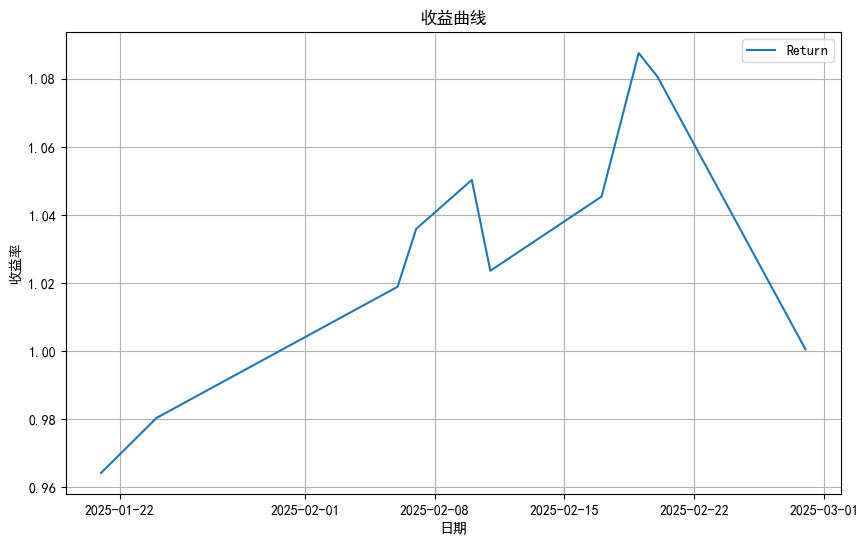

In [16]:
plot(ddwndx, 'cumulative_returns')

In [17]:
dwndx['r_pct'] = dwndx['real_open']/dwndx['open_price']

In [ ]:
pd.set_option('display.max_columns', None)
dwndx.sort_values(by='r_pct', ascending=False)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_pct
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-08,673,低吸,低位N字低吸,002912.XSHE,中新赛克,2,"000012.BKDL,000003.BKDL,000038.BKDL,000006.BKD...","885459.DDBK,886021.DDBK,885929.DDBK,885521.DDB...","980753.ZHBK,980366.ZHBK",1,1,5,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,2,0.0,36.10,165.38,0.0,-4.37,30.20,31.50,-1.0,31.34,31.06,-1.0,-1.0,-1.0,-1.0,0,0,9G0080,低位N字低吸,112.31,12.10,6,144.00,2.13,8,2025-02-15 18:31:34,0.037748,0.036748,0.028477,0.027477,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,31.22,1.033775
2024-09-26,1581,低吸,低位N字低吸,000736.XSHE,中交地产,1,"000038.BKDL,000015.BKDL,000004.BKDL,000017.BKDL","885620.DDBK,885694.DDBK,886021.DDBK,885741.DDB...",980358.ZHBK,1,1,36,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,3,0.0,356.94,363.30,0.0,-2.81,10.02,11.34,-1.0,11.46,11.55,-1.0,-1.0,-1.0,-1.0,0,0,9G0080,低位N字低吸,49.14,-23.59,34,81.41,-19.52,13,2025-02-15 17:59:15,0.143713,0.142713,0.152695,0.151695,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,10.28,1.025948
2024-09-12,1263,低吸,低位N字低吸,600662.XSHG,外服控股,1,"000012.BKDL,000023.BKDL,000010.BKDL,000037.BKD...","885520.DDBK,885586.DDBK,886021.DDBK,886072.DDB...","980473.ZHBK,980339.ZHBK",4,1,47,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0.0,181.52,311.31,0.0,-9.57,4.25,4.23,-1.0,4.10,4.16,-1.0,-1.0,-1.0,-1.0,0,0,9G0080,低位N字低吸,75.81,-11.10,5,97.59,-5.56,1,2025-02-15 17:50:37,-0.035294,-0.036294,-0.021176,-0.022176,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,4.35,1.023529
2024-12-26,1735,低吸,低位N字低吸,603350.XSHG,安乃达,1,,,980474.ZHBK,-1,-1,14,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,2,0.0,1053.08,564.62,0.0,-5.38,35.71,37.76,-1.0,38.38,39.46,-1.0,-1.0,-1.0,-1.0,0,0,9G0080,低位N字低吸,-68.27,-19.81,42,16.00,-25.85,14,2025-02-15 19:16:27,0.074769,0.073769,0.105013,0.104013,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,36.53,1.022963
2024-11-14,1001,低吸,低位N字低吸,003016.XSHE,欣贺股份,1,,,,-1,-1,-1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,3,0.0,131.50,340.64,0.0,-0.47,8.50,8.05,-1.0,7.97,7.72,-1.0,-1.0,-1.0,-1.0,0,0,9G0080,低位N字低吸,86.23,-10.68,2,134.24,-9.19,2,2025-02-15 18:37:04,-0.062353,-0.063353,-0.091765,-0.092765,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,8.68,1.021176
2025-01-14,652,低吸,低位N字低吸,002397.XSHE,梦洁股份,2,,,,-1,-1,-1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,5,0.0,83.46,223.54,0.0,-2.63,2.96,3.15,-1.0,3.14,3.11,-1.0,-1.0,-1.0,-1.0,0,0,9G0080,低位N字低吸,80.90,2.93,5,69.16,-1.63,2,2025-02-15 19:30:25,0.060811,0.059811,0.050676,0.049676,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3.02,1.020270
2024-12-24,1581,低吸,低位N字低吸,603215.XSHG,比依股份,2,,,,-1,-1,-1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,2,0.0,124.25,190.43,0.0,-4.78,16.12,16.59,-1.0,16.35,15.61,-1.0,-1.0,-1.0,-1.0,0,0,9G0080,低位N字低吸,-46.73,-107.61,47,46.87,-32.19,11,2025-02-15 19:13:59,0.014268,0.013268,-0.031638,-0.032638,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,16.44,1.019851
2025-02-06,2306,低吸,低位N字低吸,002394.X

: 

In [ ]:
ddwndx['r_return'].plot(kind='hist', bins=30, density=True, edgecolor='black')